###### Inicialização

In [1]:
!pip install openml giotto-tda meteostat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.1/526.1 KB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.6/452.6 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.7 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11732 sha256=e06d745498b3525e5b9f09d11c8bd04fff43c332c80942fd802a62faa952da88
  Stored in directory: /root/.cache/pip/wheels/a2/de/68/bf3972de3ecb31e32bef59a7f4c75f0687a3674c476b347c14
Successfully built liac-arff


In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, date
from IPython.display import Markdown
from itertools import product
import statsmodels.api as sm
from statsmodels.graphics import tsaplots as tsa

from sklearn import metrics
from sklearn.feature_selection import mutual_info_regression
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor

from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from openml.datasets.functions import get_dataset

from meteostat import Point, Daily, Hourly

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (22,6)
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

In [3]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["figure.figsize"] = (22,6)

Captura dos dados de temperatura

In [4]:
start = datetime(2012, 1, 1)
end = datetime(2022, 10, 31)

location = Point(-11.0056387, -37.2432436) #Aracaju

aracaju = Daily(location, start, end)
serie_aracaju = aracaju.fetch()

serie_aracaju.tavg.fillna(serie_aracaju.tavg.mean(),inplace=True)

In [5]:
start = datetime(2022, 1, 1)
end = datetime(2022, 10, 31)

location = Point(-11.0056387, -37.2432436) #Aracaju

aracaju = Hourly(location, start, end)
intratiaria_aracaju = aracaju.fetch()

intratiaria_aracaju.temp.fillna(intratiaria_aracaju.temp.mean(),inplace=True)

# Análise de Séries temporais (Sessão 17)
---
Sistemas Dinâmicos

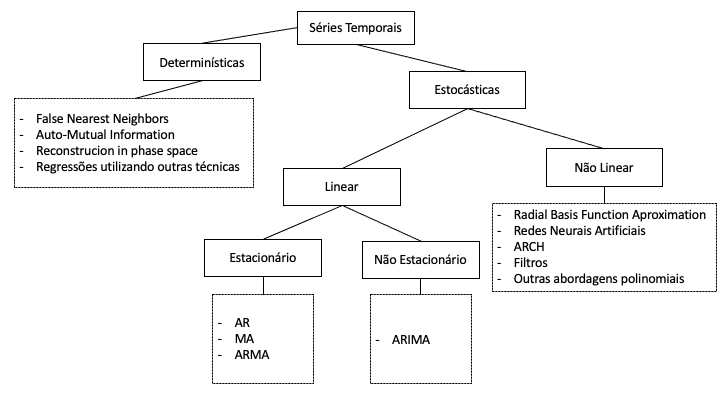

Imagem adaptada do paper [Classification of Time Series Generation Processes using Experimental Tools: A Survey and Proposal of an Automatic and Systematic Approach](https://www.researchgate.net/publication/216886255_Classification_of_Time_Series_Generation_Processes_using_Experimental_Tools_A_Survey_and_Proposal_of_an_Automatic_and_Systematic_Approach)

## Séries Determinísticas

A Teoria do Aprendizado Estatístico é a base para provar, matematicamente, que nossos modelos de aprendizado de máquina são realmente capazes de aprender (também conhecido como generalizar). Para que essas garantias se mantenham, algumas suposições sobre os dados que estamos tentando modelar devem ser definidas, uma delas é:

- Os exemplos devem ser amostrados de maneira i.i.d

Quando estamos lidando com uma série temporal, os exemplos de nosso conjunto de dados são quase independentes uns dos outros (se forem, então sua série provavelmente é uma série aleatória).

Portanto, a teoria dos sistemas dinâmicos tem algumas maneiras que podemos usar para quebrar essa dependência de tempo entre nossos pontos de dados, para que possamos usar algoritmos de aprendizado de máquina padrão para nossas previsões.

- Séries Determinísticas: depende rigorosamente de observações passadas. Por exmplo:
\begin{align}
x_t = r \cdot x_{t-1} \cdot (1 - x_{t-1})
\end{align}
- Séries Estocásticas: sequência de observações e relações aleatórios que seguem funções de probabilidade e podem mudar com o tempo. Por exmplo:
\begin{align}
x_t = x_{t-1} + N(\mu,\sigma^2)
\end{align}


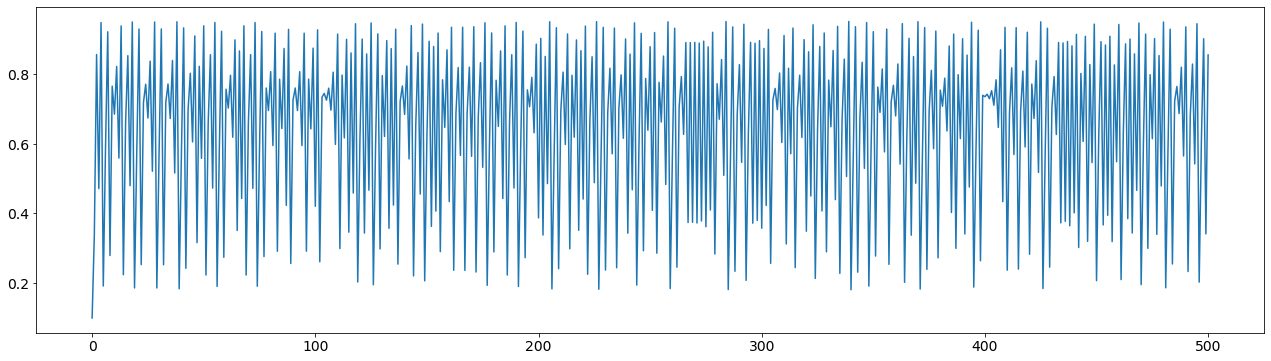

In [6]:
r = 3.8
x = [0.1]
N = 500

for n in range(0,N):
  x.append( r*x[n]*(1.-x[n]) )

mapa_logistico = pd.Series(x)
_ = mapa_logistico.plot()

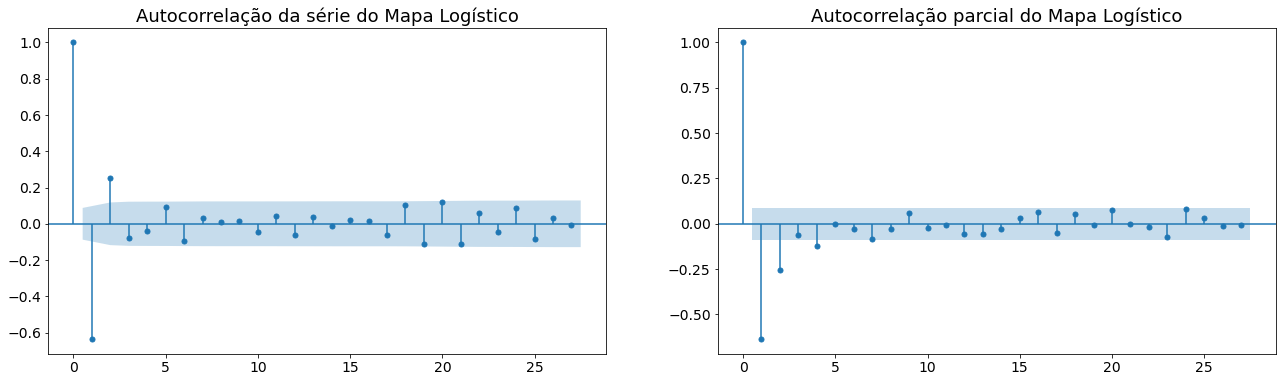

In [7]:
fig, axs = plt.subplots(1,2, figsize=(22,6))
tsa.plot_acf(mapa_logistico, ax = axs[0], title="Autocorrelação da série do Mapa Logístico")
_ = tsa.plot_pacf(mapa_logistico, ax = axs[1], title="Autocorrelação parcial do Mapa Logístico")

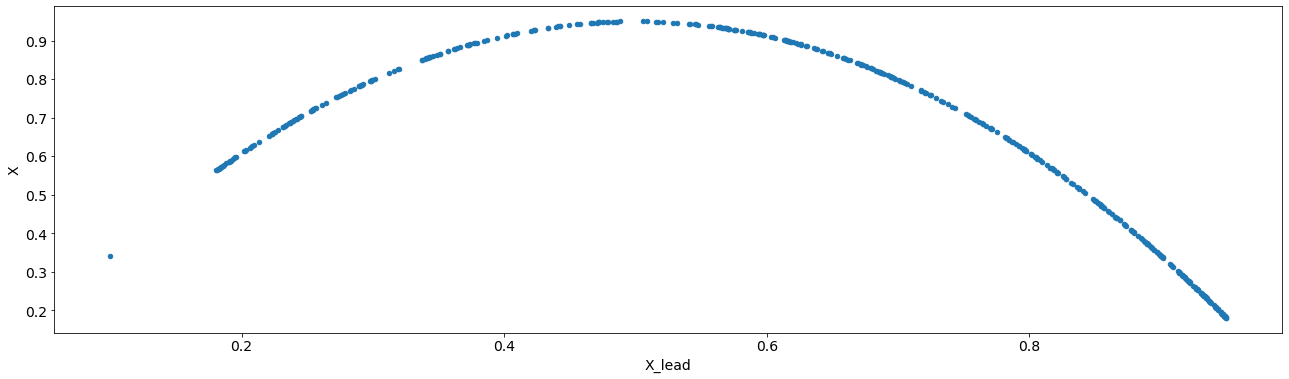

In [8]:
mapa_log = pd.Series(x).rename("X").to_frame()
mapa_log["X_lead"] = mapa_log.X.shift(1)
_ = mapa_log.plot(kind="scatter", x="X_lead", y="X")

### Teorema do Mergulho de Takens

Este teorema foi proposto por Takens na década de 80 e fala sobre como "mergulhar" (passar de um espaço para outro) nossas séries temporais no espaço de suas defasagens temporais, que chamamos de espaço de fase, remove a dependência temporal entre os instâncias da série.

Quanto mais determinística a série, mais claramente veremos um atrator sendo formado no espaço de fase. Um atrator pode ser visto como o 'desenho' que a série temporal gera no espaço de fase. Por exemplo, se tivermos uma função periódica ao longo do tempo, essa dependência periódica será vista como uma elipse no espaço de fase.

In [9]:
x = np.arange(1, 100 * np.pi, 0.1)

S = pd.Series(np.sin(x))

mu = 2
sigma = .2
R =  pd.Series(np.random.randn(len(x)) * sigma + mu)

X_limpo = S
X_ruido = S + R


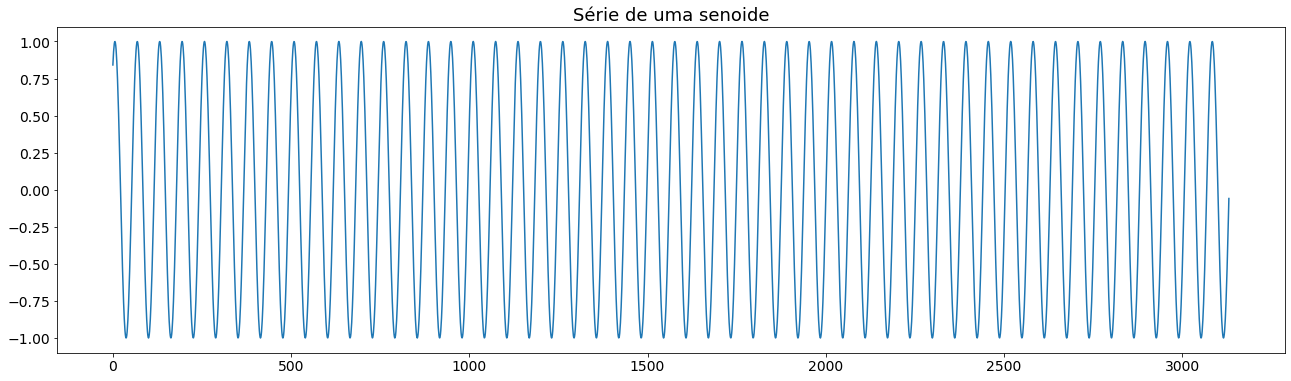

In [10]:
_ = X_limpo.plot(title="Série de uma senoide", figsize=(22,6))

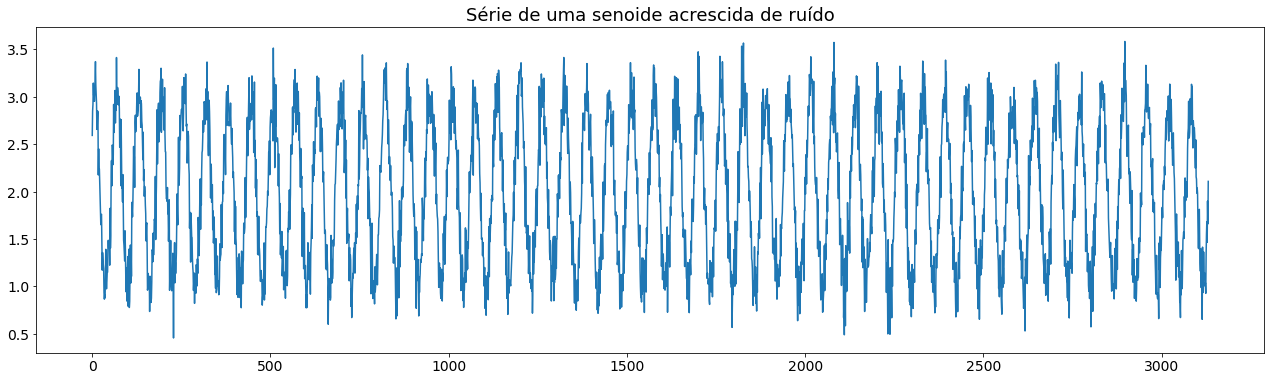

In [11]:
_ = X_ruido.plot(title="Série de uma senoide acrescida de ruído", figsize=(22,6))

In [12]:
X_limpo = X_limpo.rename("X").to_frame()
X_limpo["X_lead"] = X_limpo.X.shift(1)
X_limpo["X_lead_5"] = X_limpo.X.shift(5) 
X_limpo["X_lead_10"] = X_limpo.X.shift(10)

X_ruido = X_ruido.rename("X").to_frame()
X_ruido["X_lead"] = X_ruido.X.shift(1)
X_ruido["X_lead_5"] = X_ruido.X.shift(5)
X_ruido["X_lead_10"] = X_ruido.X.shift(10)

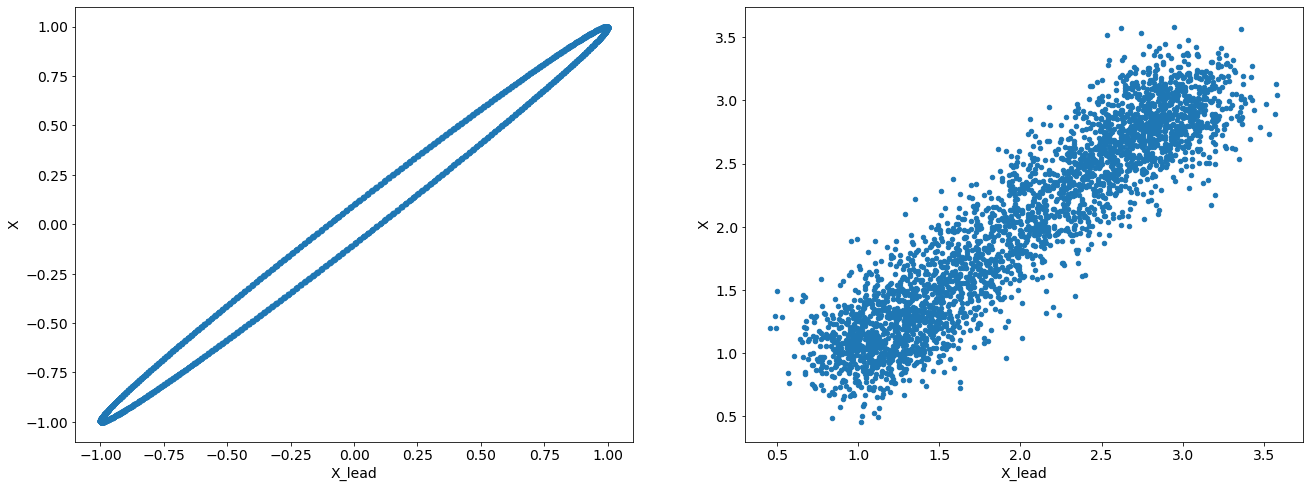

In [13]:
fig, axs = plt.subplots(1,2, figsize=(22,8))
_ = X_limpo.plot(kind="scatter", x="X_lead", y="X", ax=axs[0])
_ = X_ruido.plot(kind="scatter", x="X_lead", y="X", ax=axs[1])

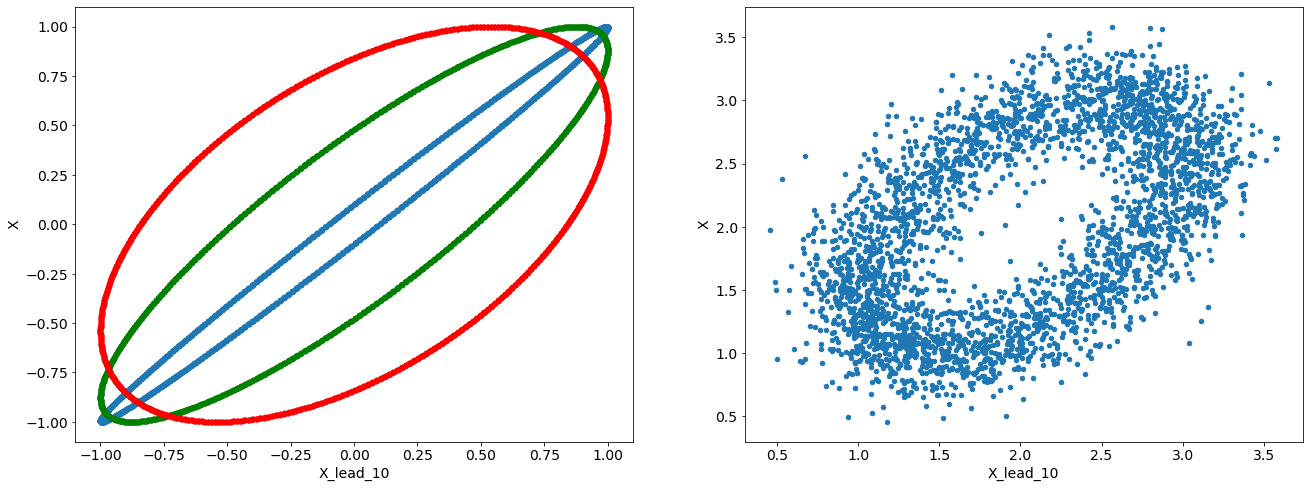

In [16]:
fig, axs = plt.subplots(1,2, figsize=(22,8))
_ = X_limpo.plot(kind="scatter", x="X_lead", y="X", ax=axs[0])
_ = X_limpo.plot(kind="scatter", x="X_lead_5", y="X", ax=axs[0],color = "g")
_ = X_limpo.plot(kind="scatter", x="X_lead_10", y="X", ax=axs[0], color="r")
_ = X_ruido.plot(kind="scatter", x="X_lead_10", y="X", ax=axs[1])

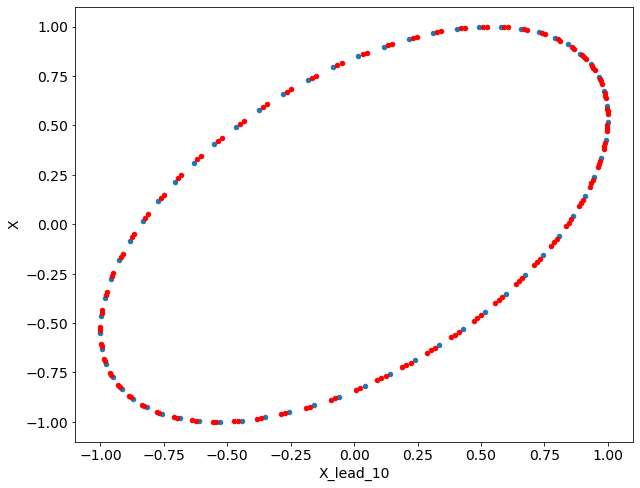

In [23]:
ax = X_limpo[:73].plot(kind="scatter", x="X_lead_10", y="X", figsize=(10,8))
_ = X_limpo[74:220].plot(kind="scatter", x="X_lead_10", y="X", ax=ax, color="r")

O teorema de incorporação de Taken afirma que, se você tiver uma série temporal $x_1,x_2,…,x_n$ amostrada de um atrator de dimensão superior por meio da série temporal multivariada

\begin{align}
  \begin{pmatrix}
    x_i \\
    x_{i+\tau} \\
    ⋮ \\
    x_{i + (d-1) + \tau}
  \end{pmatrix}
\end{align}

onde:
- $d$ -> Chamado de dimensão de incorporação, este parâmetro nos informará a dimensão do espaço de fase
- $\tau$ -> Chamado de atraso de tempo, isso nos dirá quantos atrasos de tempo cada eixo do espaço de fase representará

In [24]:
def takensEmbedding(data, delay, dimension):
    if delay*dimension > len(data):
        raise NameError('Delay times dimension exceed length of data!')    
    embeddedData = np.array([data[0:len(data)-delay*dimension]])
    for i in range(1, dimension):
        embeddedData = np.append(embeddedData, [data[i*delay:len(data) - delay*(dimension - i)]], axis=0)
    return embeddedData.T;

In [35]:
emb = takensEmbedding(X_limpo.X, dimension=2, delay=17)

fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=emb[:, 0], y=emb[:,1], z=emb[:, 1], mode='lines'
))
fig.show()

In [28]:
lorenz = pd.Series(get_dataset(42182).get_data(dataset_format='array')[0][0:, 0], name="lorenz")

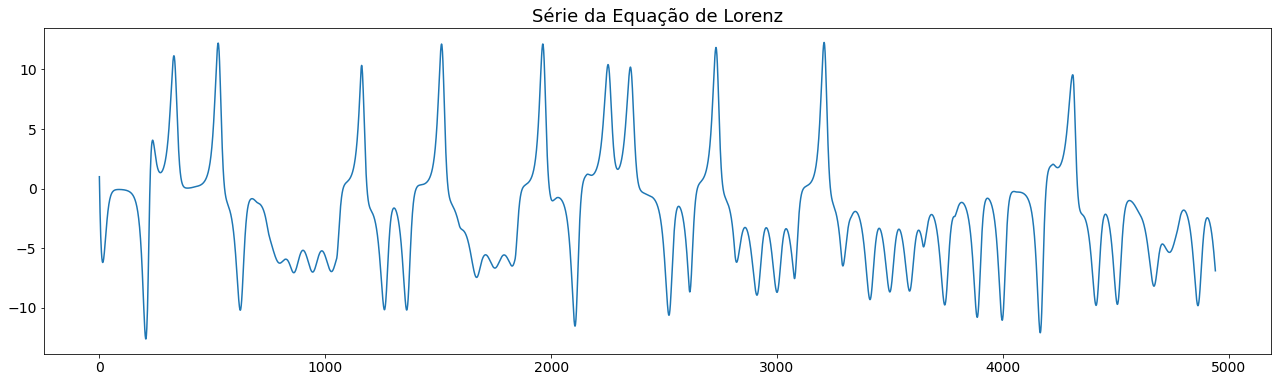

In [29]:
_ = lorenz.plot(title="Série da Equação de Lorenz")

In [30]:
emb = takensEmbedding(lorenz, dimension=3, delay=5)

fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=emb[:, 0], y=emb[:,1], z=emb[:, 2], mode='lines'
))
fig.show()

### Informação Mútua

Definimos o mínimo $x_{min}$ e máximo $x_{max}$ da série temporal. Então o intervalo $[x_{min},x_{max}]$ é dividido em um grande número de caixas. Denote por $P_k$ a probabilidade de que um elemento da série temporal esteja no $k$-esimo bin e por $P_{h,k}(τ)$ a probabilidade de $x$ estar no $h$-ésimo bin enquanto $x_{i+τ}$ está no $k$ª caixa.

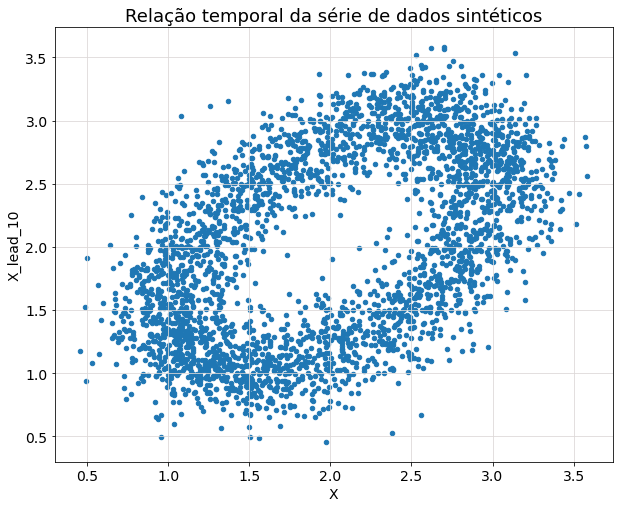

In [31]:
ax = X_ruido.plot(x="X", y="X_lead_10", kind='scatter', figsize=(10,8),
                  title="Relação temporal da série de dados sintéticos",)

plt.grid(color='#DCD8D7', linestyle='solid')

Então a informação mútua é

\begin{align}
I(τ)=−\sum_{h=1}^{nBins}\sum_{k=1}^{nBins}P_{h,k(τ)}log \frac{P_{h,k(τ)}}{P_hP_k}
\end{align}

O primeiro mínimo de $I(τ)$ em função de $τ$ fornece o atraso ideal, pois obtemos a maior informação adicionando $x_{i+τ}$. Todas as probabilidades aqui são calculadas como probabilidades empíricas.

<center>

![img](https://miro.medium.com/v2/resize:fit:720/format:webp/1*f4gd1WKovdfSSTF3SPoDlA.png)

Fonte: [A Deep Conceptual Guide to Mutual Information](https://medium.com/swlh/a-deep-conceptual-guide-to-mutual-information-a5021031fad0)
</center>

In [32]:
mi_seno = pd.Series(dtype=np.float64)
for i in range(1,100):
  mi_seno.loc[i] = mutual_info_regression(X_limpo[["X"]][i:], X_limpo.X.shift(i)[i:])[0]

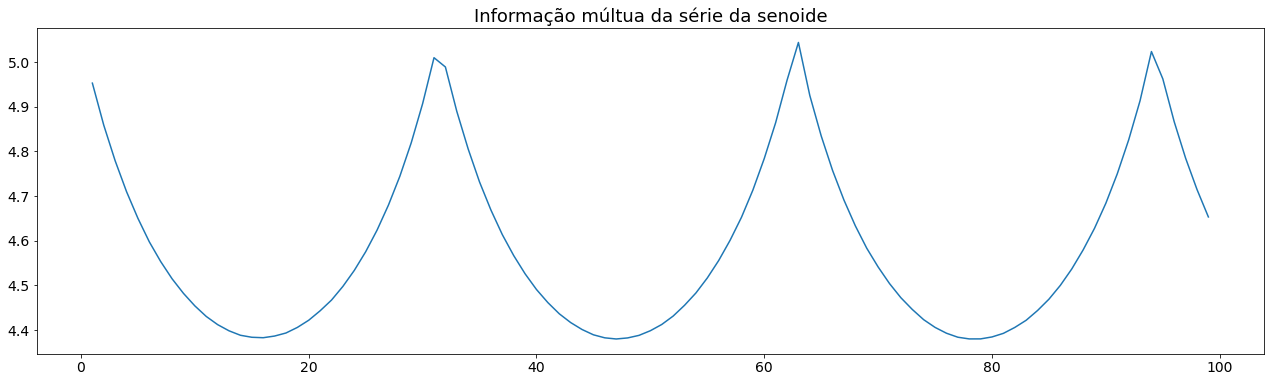

In [33]:
_ = mi_seno.plot(title = "Informação múltua da série da senoide")

In [34]:
mi_seno_diff = mi_seno.diff()
delay = mi_seno_diff[mi_seno_diff > 0].index[0]
delay

17

In [36]:
lorenz_df = lorenz.to_frame()
mi_lorenz = pd.Series(dtype=np.float64)
for i in range(1,100):
  mi_lorenz.loc[i] = mutual_info_regression(lorenz_df[["lorenz"]][i:], lorenz_df.lorenz.shift(i)[i:])[0]

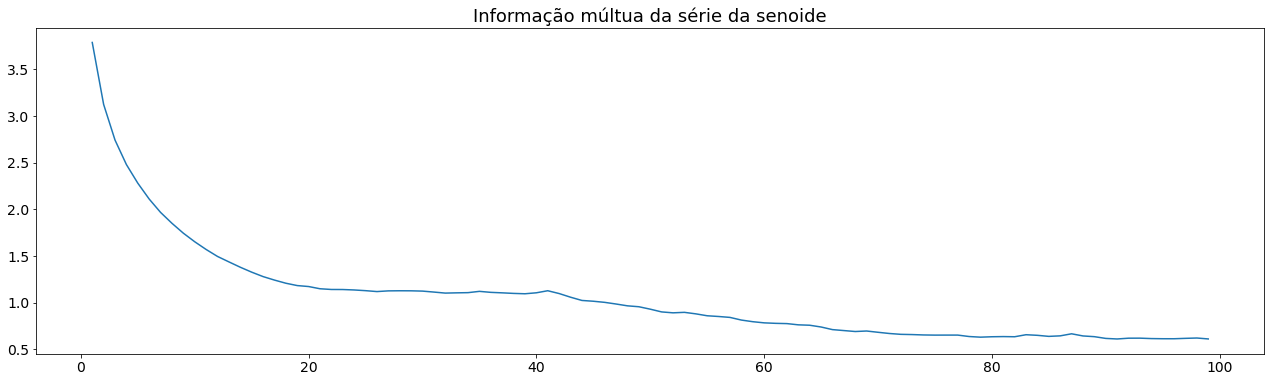

In [37]:
_ = mi_lorenz.plot(title = "Informação múltua da série da senoide")

In [38]:
mi_lorenz_diff = mi_lorenz.diff()
delay_lorenz = mi_lorenz_diff[mi_lorenz_diff > 0].index[0]
delay_lorenz

27

### False nearest neighbours
Agora explicamos a medida para determinar a dimensão de incorporação correta. A medida usada aqui é chamada de falsos vizinhos mais próximos e baseia-se na suposição de que o desdobramento, ou seja, a incorporação em dimensões subseqüentemente maiores, um sistema determinístico é suave. Ou seja, os pontos que estão próximos em uma dimensão de incorporação devem estar próximos na próxima dimensão de incorporação superior. Portanto, se tivermos um ponto pi com vizinho pj , ou seja, ||pi−pj||<ϵ para algum ϵ>0, verificamos se a distância normalizada Ri para a próxima dimensão, ou seja, a próxima coordenada, é maior que o triplo Rtr= 10 : 

\begin{align}
R_i=\frac{|x_{i+mτ}−x_{j+mτ}|}{||p_i−p_j||}>R_{tr}.
\end{align}

Se for esse o caso, temos falso vizinho mais próximo. A dimensão de incorporação correta é alcançada se o número de falsos vizinhos mais próximos for muito pequeno.

In [39]:
def false_nearest_neighbours(data, delay, embeddingDimension):
    embeddedData = takensEmbedding(data, delay, embeddingDimension);

    #the first nearest neighbour is the data point itself, so we choose the second one
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(embeddedData)
    distances, indices = nbrs.kneighbors(embeddedData)

    #two data points are nearest neighbours if their distance is smaller than the standard deviation
    epsilon = np.std(distances.flatten())
    nFalseNN = 0
    for i in range(0, len(data)-delay*(embeddingDimension+1)):
        if (0 < distances[i,1]) and (distances[i,1] < epsilon) and ( (abs(data[i+embeddingDimension*delay] - data[indices[i,1]+embeddingDimension*delay]) / distances[i,1]) > 10):
            nFalseNN += 1;
    return nFalseNN

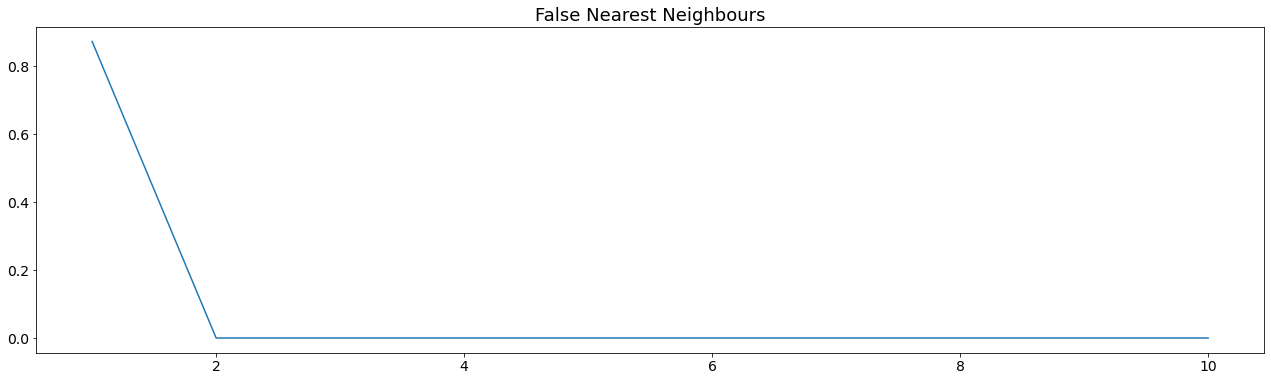

In [40]:
nFNN = pd.Series(dtype=np.float64)
for i in range(1,11):
    nFNN.loc[i] = false_nearest_neighbours(X_limpo.X, delay, i) / len(X_limpo.X)

_ = nFNN.plot(title="False Nearest Neighbours")

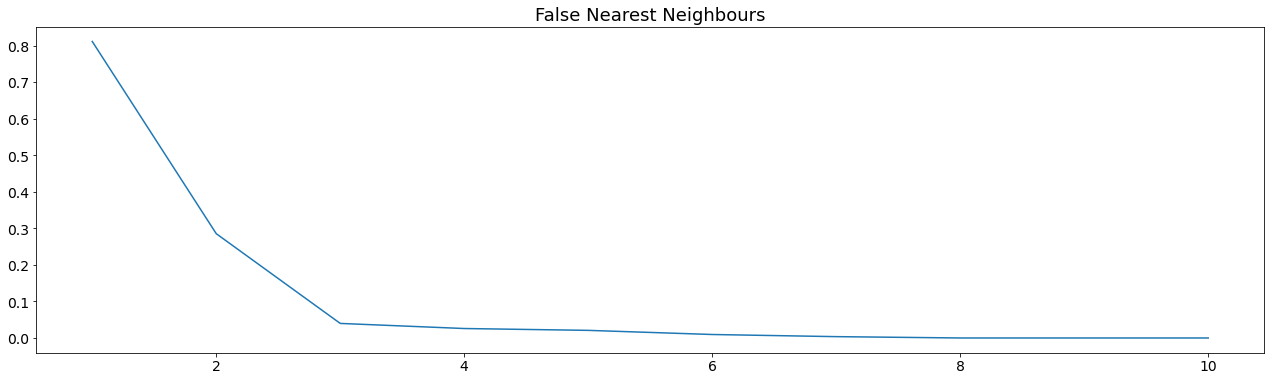

In [41]:
nFNN = pd.Series(dtype=np.float64)
for i in range(1,11):
    nFNN.loc[i] = false_nearest_neighbours(lorenz, delay_lorenz, i) / len(lorenz)

_ = nFNN.plot(title="False Nearest Neighbours")

## Previsão com o Espaço Fase

Ok, a ideia aqui é que depois de feito o embedding, temos uma matriz X com os atrasos da nossa série temporal em um novo espaço. Podemos usar as primeiras m-1 entradas nesta matriz como recursos para nosso regressor prever a última coluna.

Vamos ver como isso fica no código, onde usaremos um conjunto de validação:

In [42]:
tau = delay_lorenz
d = 3
forecast_horizon = 300

emb = takensEmbedding(lorenz, d, tau)
    
# Divide into train and test
X = emb[:, 1:]
y = emb[:, 0]

X_train = X[:len(X)-forecast_horizon, :]
y_train = y[:len(y)-forecast_horizon]
X_test = X[len(X)-forecast_horizon:, :]
y_test = y[len(y)-forecast_horizon:]

# Fit the regressor on the training data
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Predict the test data
preds = rf.predict(X_test)

print(f'R²: {metrics.r2_score(y_test, preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_test, preds, squared=False)}')

# Plot the result
preds_ = [np.nan for i in range(len(y)-forecast_horizon)] + list(preds)
t = [i for i in range(len(y))]
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=t, y=y, mode='lines'
))
fig.add_trace(go.Scatter(
    x=t, y=preds_, mode='lines', line=dict(color='red')))
fig.show()

R²: 0.9907121685982547
RMSE: 0.20519869524587403


## Aplicando para os dados de temperatura

\begin{align}
SN = \frac{x_i - \overline{x}}{\sigma_x}
\end{align}

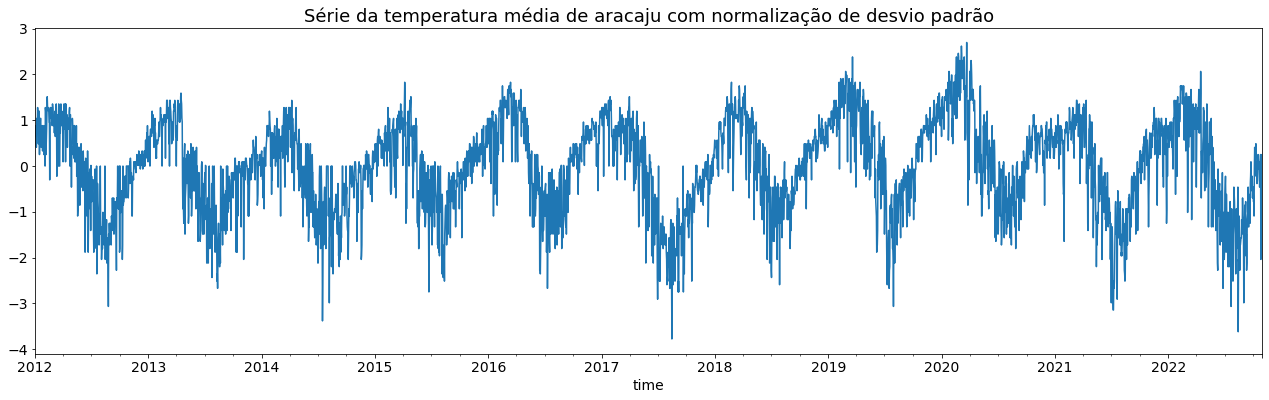

In [43]:
serie_aju = ((serie_aracaju.tavg - serie_aracaju.tavg.mean()) / serie_aracaju.tavg.std()).to_frame()
_ = serie_aju.tavg.plot(title="Série da temperatura média de aracaju com normalização de desvio padrão")

In [44]:
split = int(len(serie_aju) * 80 / 100) #encontrando o ponto de separação de 80% para treino e 20% para teste
treino, teste = serie_aju[:split], serie_aju[split:]

### Encontrando o atraso temporal a partir da Informação Mútua

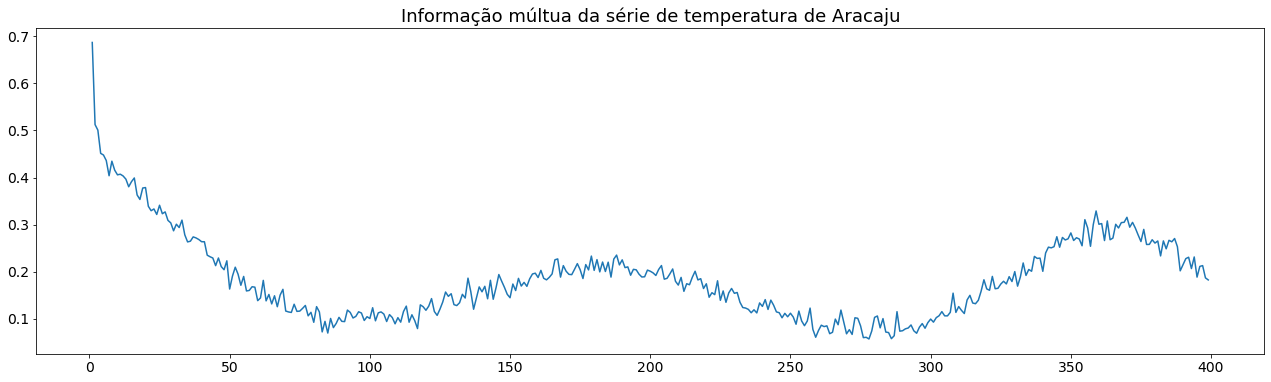

In [45]:
mi_aju = pd.Series(dtype=np.float64)
for i in range(1,400):
  mi_aju.loc[i] = mutual_info_regression(treino[["tavg"]][i:], treino.tavg.shift(i)[i:])[0]

_ = mi_aju.plot(title = "Informação múltua da série de temperatura de Aracaju")

In [46]:
mi_aju_diff = mi_aju.diff()
delay_aju = mi_aju_diff[mi_aju_diff > 0].index[0]
delay_aju

8

### Encontrando a dimensão de embedding a partir do False Nearest Neighbours

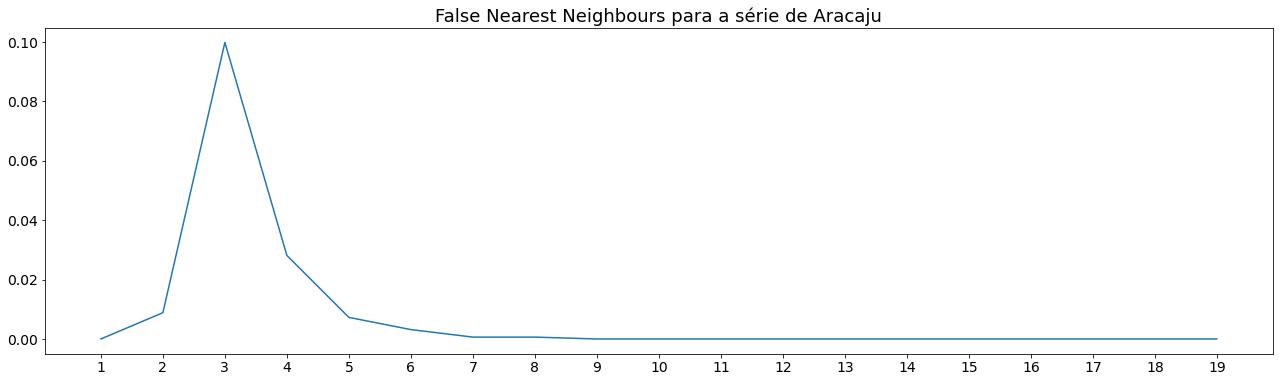

In [47]:
nFNN_aju = pd.Series(dtype=np.float64)
for i in range(1,20):
    nFNN_aju.loc[i] = false_nearest_neighbours(treino.tavg, delay_aju, i) / len(treino.tavg)

_ = nFNN_aju.plot(title="False Nearest Neighbours para a série de Aracaju", xticks=np.arange(1, 20, 1))

In [48]:
emb = takensEmbedding(treino.tavg, dimension=5, delay=delay_aju)

fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=emb[:, 0], y=emb[:,1], z=emb[:, 2], mode='lines'
))
fig.show()

### Previsibilidade

In [49]:
d = 5

In [50]:
treino_emb = takensEmbedding(treino.tavg, dimension=d, delay=delay_aju)
teste_emb = takensEmbedding(teste.tavg, dimension=d, delay=delay_aju)

In [51]:
X_train = treino_emb[:, 1:]
y_train = treino_emb[:, 0]
X_test = teste_emb[:, 1:]
y_test = teste_emb[:, 0]

# Fit the regressor on the training data
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Predict the test data
preds = rf.predict(X_test)

print(f'R²: {metrics.r2_score(y_test, preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_test, preds, squared=False)}')

y_train = pd.Series(y_train, name="Treino",  index = treino.index[:-(d*delay_aju)])
y_test = pd.Series(y_test,name="Teste", index = teste.index[:-(d*delay_aju)])
preds = pd.Series(preds,name="Predição", index = teste.index[:-(d*delay_aju)])

R²: 0.5552866821452781
RMSE: 0.7060026435664994


Revertendo a normalização

In [53]:
y_train = y_train * serie_aracaju.tavg.std() + serie_aracaju.tavg.mean()
y_test = y_test * serie_aracaju.tavg.std() + serie_aracaju.tavg.mean()
preds = preds * serie_aracaju.tavg.std() + serie_aracaju.tavg.mean()

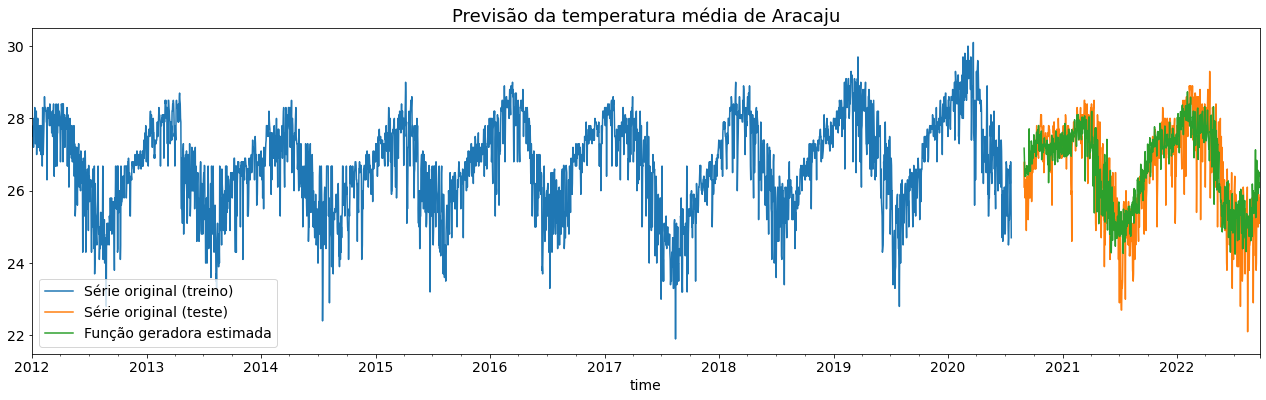

In [54]:
ax = y_train.plot(title = "Previsão da temperatura média de Aracaju",
                  label="Série original (treino)", legend= True)
y_test.plot(ax = ax, label="Série original (teste)", legend= True)
_ = preds.plot(ax=ax, label="Função geradora estimada", legend= True)

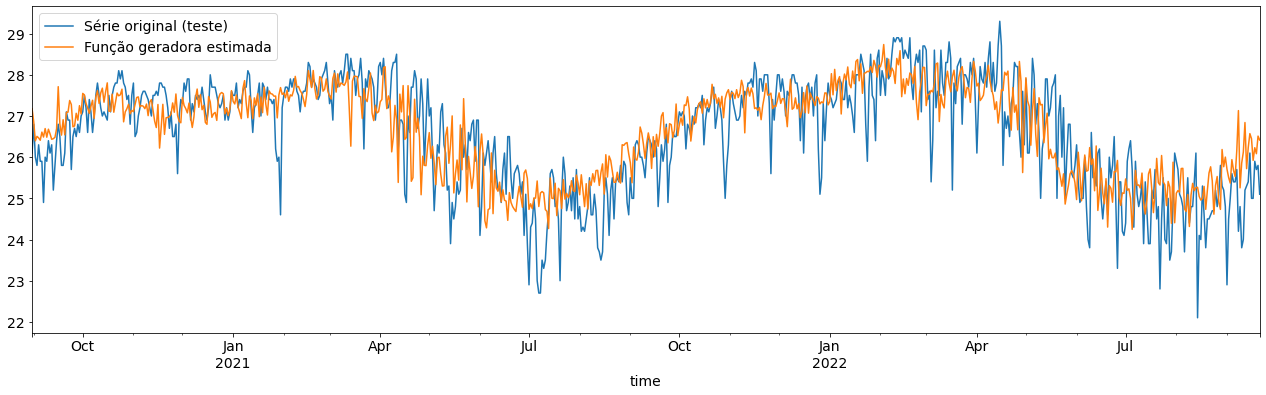

In [55]:
ax = y_test.plot(label="Série original (teste)", legend= True)
_ = preds.plot(ax=ax, label="Função geradora estimada", legend= True)

## Exercício

1. Ajuste um modelo ARIMA para a série de mapa logístico
2. Utilize a técnica de Informação Mútua para encontrar o melhor atraso temporal para a série de temperatura de sua cidade. 
3. Utilize a técnica de False Nearest Neighbours para encontrar o melhor dimensão de mergulho para a série de temperatura de sua cidade.
4. Vizualize o espaço fase para estes parâmetros encontrados.

## Referêcias
- https://www.kaggle.com/code/tigurius/introduction-to-taken-s-embedding
- https://towardsdatascience.com/time-series-forecasting-with-dynamical-systems-methods-fa4afdf16fd0
- https://valeman.medium.com/mutual-information-for-time-series-forecasting-in-python-377d36ded102
- https://medium.com/swlh/a-deep-conceptual-guide-to-mutual-information-a5021031fad0
- https://giotto-ai.github.io/gtda-docs/latest/notebooks/topology_time_series.html


# Pós trabalho
- https://github.com/pvlachas/RNN-Lyapunov-Spectrum